# ***Como criar um timelapse e exportar as imagens prontas para utilizar no seu relatório?***

Neste exemplo vamos:

* definir a área de estudo
* criar um índice de vegetação 
* criar as propriedades de um timelapse
* exportar as imagens com norte e escala

In [ ]:
# execute a instalação apenas uma vez, após a instalação reinicie a sessão e prossiga

# instala as bibliotecas Proj e GEOS
!apt-get install libproj-dev proj-bin
!apt-get install libgeos-dev

# instala cartopy e geemap com todas as dependências pré-construídas
!pip install cartopy geemap==0.16.0 earthengine-api

In [ ]:
##`Precisaremos atualizar nosso shapely 
!pip uninstall shapely
!pip install shapely --no-binary shapely

Found existing installation: Shapely 1.8.4
Uninstalling Shapely-1.8.4:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Shapely-1.8.4.dist-info/*
    /usr/local/lib/python3.7/dist-packages/Shapely.libs/libgeos-35e678a0.so.3.10.3
    /usr/local/lib/python3.7/dist-packages/Shapely.libs/libgeos_c-c8ec7514.so.1.16.1
    /usr/local/lib/python3.7/dist-packages/shapely/*
Proceed (y/n)? y
  Successfully uninstalled Shapely-1.8.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.4-cp37-cp37m-linux_x86_64.whl size=669452 sha256=f6c445a60d816353d2f5999dcf0a6d0951dbeb96f7a656861cb273b9512c4adc
  Stored in directory: /root/.cache/pip/wheels/0b/f0/55/139a0ab07fbf91378f9b

In [ ]:
##Importando as bibliotecas
import ee
import geemap.foliumap as geemap
from geemap import cartoee
import os
##Permitirá os plots necessários para o gif
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage
##Vai permitir ler a norte como uma imagem
import imageio

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [ ]:
##Inicialize e autenticação 
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=e-kvOQsULqdqXGUNsUI2L2h2uRjMQ0m6shIOIlpKUC4&tc=WxepY1nKnReV3CZEJMipxZXSzKMiJb2CzCx1M0HnSPk&cc=8zDKqyuqieqAOwZB6FihSFPiaa7XQI3O7XFP8a8dt1E

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJrOY7Gc6edq4K34Dk4bWy-nh38KFuzWk_pWnGRIPoITYop3qas11mg

Successfully saved authorization token.


In [ ]:
##Máscara de nuvens 
def maskL8sr(image):

    qaMask = image.select('QA_PIXEL').bitwise_and(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    ###Fator de escala
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

    return image.addBands(opticalBands, None, True)\
    .addBands(thermalBands, None, True).updateMask(qaMask)\
    .updateMask(saturationMask)

##Função NDVI
def Ndvi(img):  
    Ndvi_image = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return img.addBands(Ndvi_image).copyProperties(img, ["system:time_start"]).set('date', img.date().format('YYYY-MM-dd'))

In [ ]:
##Criando nossa imagem collection
lon = -45.5630
lat = -12.9484
start_year = 2013
end_year = 2022

##Definindo o intervalo de tempo
point = ee.Geometry.Point(lon, lat)
years = ee.List.sequence(start_year, end_year)


##Função para selecionar a melhor imagem no período de tempo estimado
def get_best_image(year):

    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    image = (
        ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                                .filterBounds(point)
                                .filterDate(start_date, end_date)
                                .filter(ee.Filter.lt('CLOUD_COVER',10))
                                .map(maskL8sr)
                                .map(Ndvi)
                                .sort("CLOUD_COVER")
                                .first()
                                 
    )
    return ee.Image(image)

collection = ee.ImageCollection(years.map(get_best_image))

In [ ]:
##Crie um mapa interativo 
Map = geemap.Map()
##Visualizando a imagem
vis_ = {"bands": ['SR_B4', 'SR_B3', 'SR_B2'], "min": 0, "max": 0.19}
vis_params = {"palette": ['red','yellow','green'], "min": 0, "max": 0.8}

ls8 = ee.Image(collection.first())
imagem = ee.Image(collection.select('NDVI').first())
Map.addLayer(ls8, vis_, 'Primeira imagem')
Map.addLayer(imagem, vis_params, 'NDVI')
Map.setCenter(lon, lat, 10)
Map

In [ ]:
##Downaload do norte como png
!wget https://i.pinimg.com/originals/2e/43/17/2e4317cbf128511ff28c809832b7b673.png
!mv 2e4317cbf128511ff28c809832b7b673.png norte.png

--2022-09-14 21:58:40--  https://i.pinimg.com/originals/2e/43/17/2e4317cbf128511ff28c809832b7b673.png
Resolving i.pinimg.com (i.pinimg.com)... 146.75.76.84, 2600:1407:3c00:5::17d5:352a, 2600:1407:3c00:5::17d5:3517, ...
Connecting to i.pinimg.com (i.pinimg.com)|146.75.76.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22671 (22K) [image/png]
Saving to: ‘2e4317cbf128511ff28c809832b7b673.png’

2e4317cbf128511ff28 100%[===================>]  22.14K  --.-KB/s    in 0.001s  

2022-09-14 21:58:40 (28.3 MB/s) - ‘2e4317cbf128511ff28c809832b7b673.png’ saved [22671/22671]



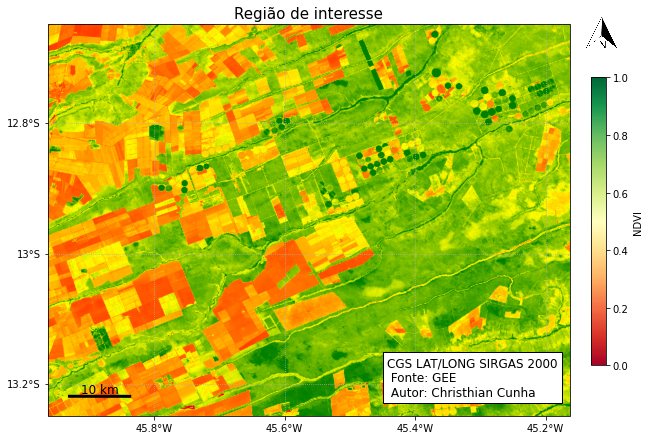

In [ ]:
##Como visualizar a região de interesse
w = 0.4
h = 0.3
region = [lon + w, lat - h, lon - w, lat + h]

fig = plt.figure(figsize=(10, 8))

# use cartoee para obter um mapa
ax = cartoee.get_map(imagem.select('NDVI'), region=region, vis_params=vis_params)

# adiciona linhas de grade ao mapa em um intervalo especificado
cartoee.add_gridlines(ax, interval=[0.2, 0.2], linestyle=":")


#adiciona seta norte
north_arrow_dict = {
    "text": "N",
    "xy": (0.95, 0.95),
    "arrow_length": 0.15,
    "text_color": "white",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center",
}
# cartoee.add_north_arrow(ax, **north_arrow_dict)

#adiciona barra de escala
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 12,
    "color": "black",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}
cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

##Adicione a barra de legenda
cartoee.add_colorbar(
    ax,
    vis_params={'min': 0, 'max': 1},
    cmap='RdYlGn',
    loc="right",
    label="NDVI",
    orientation="vertical",
)

#anotacoes
n = image.imread('norte.png')
addNorte=OffsetImage(n,zoom=0.055)
addNorte.set_offset((580,385))
base=ax.add_artist(addNorte)

##Adicionar informações ao texto
ax.text(0.65,0.05,'CGS LAT/LONG SIRGAS 2000''\n Fonte: GEE \n Autor: Christhian Cunha',
        transform=ax.transAxes, fontsize= 12, bbox = dict(facecolor = 'white'))
# ax.text(0.65,0.02,'Fonte: GEE',transform=ax.transAxes, fontsize= 12)
ax.set_title(label='Região de interesse', fontsize=15)


##Visualizar a imagem
show()

In [ ]:
##Criar uma tabela com as datas e o percentual de nuvens nas imagens
lista = ee.List(collection.reduceColumns(ee.Reducer.toList(1), ['system:id']).values().get(0))
lista.get(1).getInfo()

['LANDSAT/LC08/C02/T1_L2/LC08_220069_20140607']

In [ ]:
##Criar uma tabela com as datas e o percentual de nuvens nas imagens
data = ee.List(collection.reduceColumns(ee.Reducer.toList(1), ['date']).values().get(0))
str(data.get(1).getInfo())[2:12]

'2014-06-07'

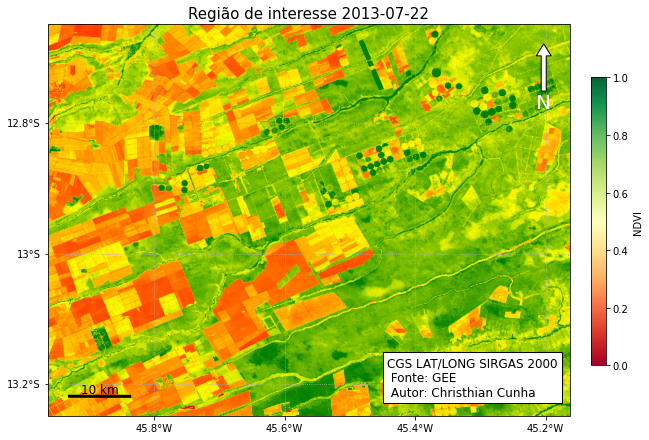

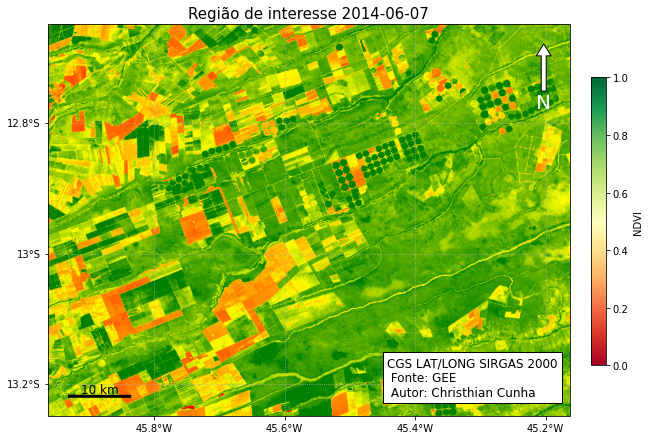

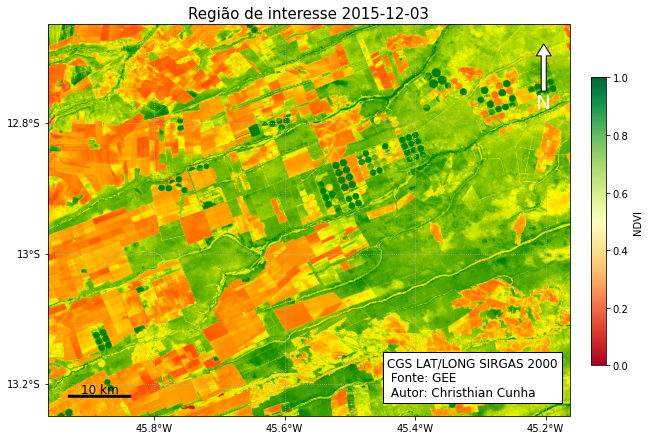

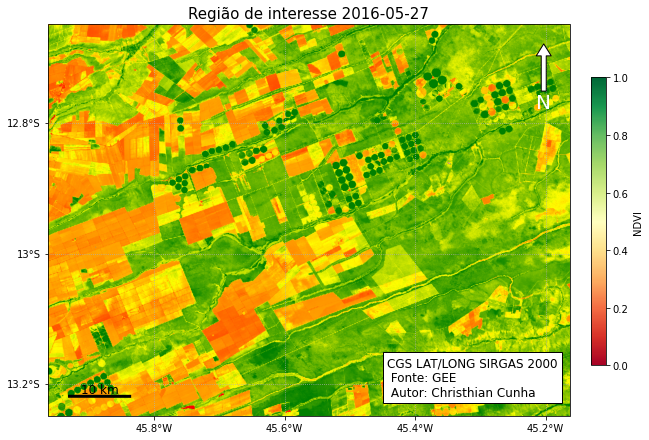

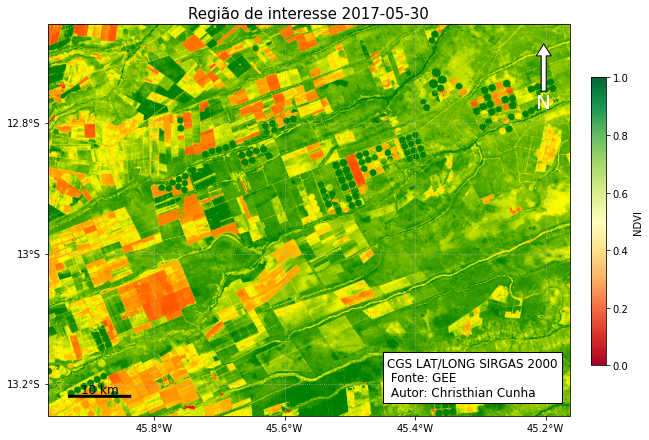

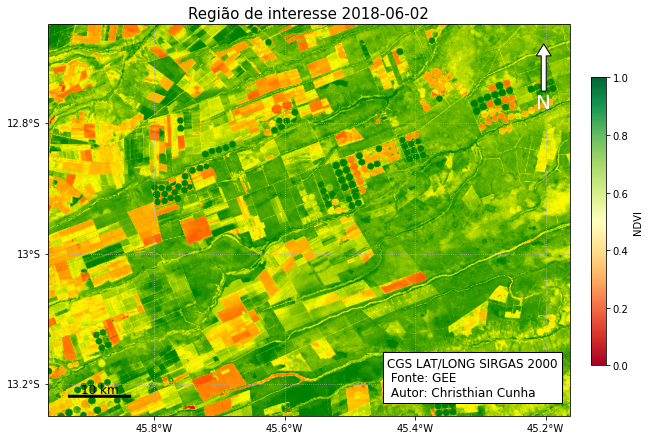

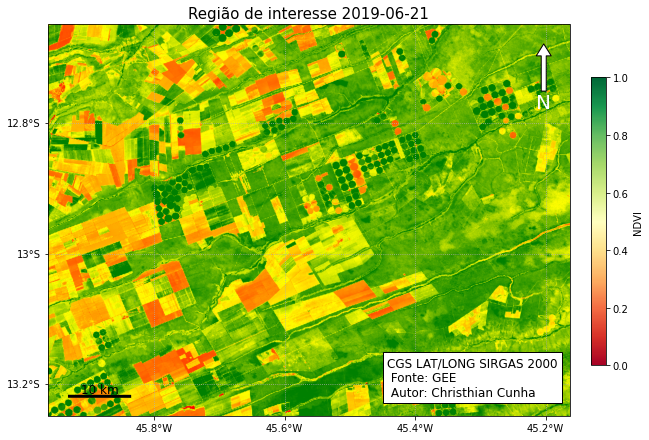

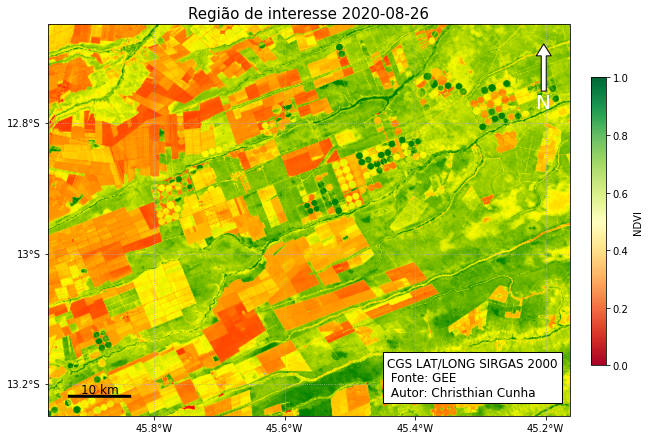

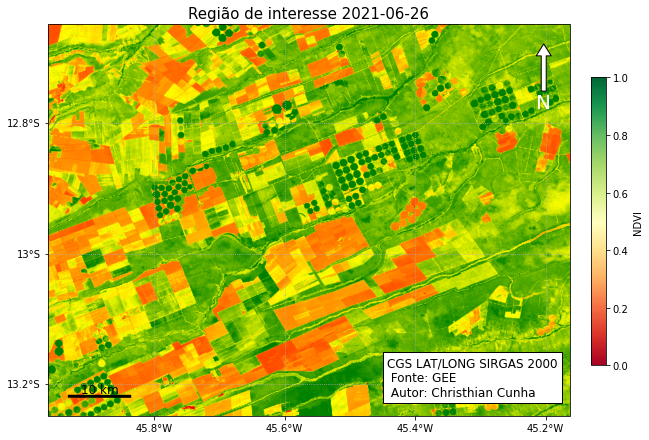

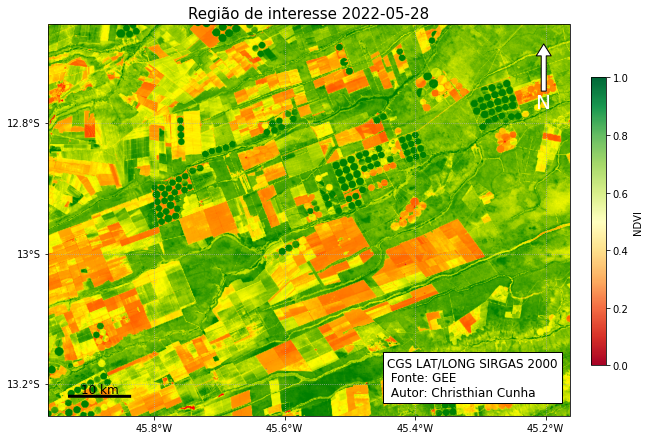

In [ ]:
##Vamos criar uma estrutura para repetir o processo de plot e visualizar todas as imagens e salvar cada uma delas 
for i in range(len(lista.getInfo())):

    ##Definido a área de interesse
    w = 0.4
    h = 0.3
    region = [lon + w, lat - h, lon - w, lat + h]

    fig = plt.figure(figsize=(10, 8))

    ##Criamos duas listas para extrair e filtras as imagens
    item = lista.get(i).getInfo()
    date = data.get(i).getInfo()
    imagem = collection.select('NDVI').filter(ee.Filter.eq('date',str(date)[2:12]))
    # use cartoee para obter um mapa
    ax = cartoee.get_map(imagem, region=region, vis_params=vis_params)

    # adiciona linhas de grade ao mapa em um intervalo especificado
    cartoee.add_gridlines(ax, interval=[0.2, 0.2], linestyle=":")

    # Add o norte
    north_arrow_dict = {
        "text": "N",
        "xy": (0.95, 0.95),
        "arrow_length": 0.15,
        "text_color": "white",
        "arrow_color": "white",
        "fontsize": 20,
        "width": 5,
        "headwidth": 15,
        "ha": "center",
        "va": "center",
    }
    cartoee.add_north_arrow(ax, **north_arrow_dict)

    # add a barra de escala
    scale_bar_dict = {
        "length": 10,
        "xy": (0.1, 0.05),
        "linewidth": 3,
        "fontsize": 12,
        "color": "black",
        "unit": "km",
        "ha": "center",
        "va": "bottom",
    }
    cartoee.add_scale_bar_lite(ax, **scale_bar_dict)
    
    ##Add a barra de legenda
    cartoee.add_colorbar(
        ax,
        vis_params={'min': 0, 'max': 1},
        cmap='RdYlGn',
        loc="right",
        label="NDVI",
        orientation="vertical",
    )

    # #anotacoes
    # n = image.imread('norte.png')
    # addNorte=OffsetImage(n,zoom=0.055)
    # addNorte.set_offset((580,385))
    # base=ax.add_artist(addNorte)

    ##Adicionar informações ao texto
    ax.text(0.65,0.05,'CGS LAT/LONG SIRGAS 2000''\n Fonte: GEE \n Autor: Christhian Cunha',
            transform=ax.transAxes, fontsize= 12, bbox = dict(facecolor = 'white'))
    # ax.text(0.65,0.02,'Fonte: GEE',transform=ax.transAxes, fontsize= 12)
    ax.set_title(label='Região de interesse'+' '+str(date)[2:12], fontsize=15)

    plt.savefig('/content/Região de interesse'+' '+str(date)[2:12]+'.png')

    ##Visualizar a imagem
    show()

In [ ]:
##Gerando o gif com as imagens landst
cartoee.get_image_collection_gif(
    ee_ic=collection.select('NDVI'),
    out_dir=os.path.expanduser("gif"),
    out_gif="animation.gif",
    vis_params=vis_params,
    region=region,
    fps=5,
    mp4=True,
    grid_interval=(0.4, 0.4),
    plot_title="Região de interesse",
    date_format='YYYY-MM-dd',
    fig_size=(10, 8),
    dpi_plot=100,
    file_format="png",
    north_arrow_dict=north_arrow_dict,
    scale_bar_dict=scale_bar_dict,
    verbose=True,
)